### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'spotfy_genre',
    'source': 'kaggle', # ['kaggle', 'local', 'openml', 'hf']
    'remote_path': 'maharshipandya/-spotify-tracks-dataset',
    'files': ['dataset.csv'],
    'rename_files': ['spotify_data.csv'],
    'task': 'clf', # ['reg', 'clf']
    'target': 'track_genre',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/spotfy_genre.
Downloaded spotfy_genre dataset to /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/spotfy_genre


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/spotfy_genre/spotify_data.csv


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic


In [6]:
# there are way too many differnt targets -> downsample to 10 only
target_genres = ['pop', 'rock', 'hip-hop', 'jazz', 'classical', 'metal', 'electronic', 'indie', 'r-n-b', 'country']
for df in dataset_files_df:
    shape_before = df.shape
    # drop all rows which are not in the target_genres
    df.drop(df[~df['track_genre'].isin(target_genres)].index, inplace=True)
    print(f"Shape before: {shape_before}, after: {df.shape}")

Shape before: (114000, 21), after: (10000, 21)


In [7]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.5 # TODO the threshold can be changed

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)   
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index([], dtype='object')
Dataframe shape before/afrer cleaning: (10000, 21) / (10000, 20)


In [8]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['track_id']

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")

dataset_files_cleaned[0].head(n=3)

Dataframe shape before/afrer by-hand cleaning: (10000, 20) / (10000, 19)


,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
16000,Bombay Jayashri,Rehnaa Hai Terre Dil Mein,Zara Zara,58,298266,False,0.643,0.268,11,-15.073,0,0.0900,0.593,0.000002,0.316,0.620,143.813,4,classical
16001,Shankar;Ehsaan;Loy;Alisha Chinai;Shankar Mahad...,Bunty Aur Babli,Kajra Re,59,482586,False,0.484,0.898,0,-4.132,1,0.1640,0.365,0.000000,0.091,0.680,91.975,4,classical
16002,Bombay Jayashri;DJ Aftab,Hindi Slowed Reverb Bollywood Lofi,Zara Zara - Lofi,54,219437,False,0.608,0.638,11,-6.008,0,0.0292,0.581,0.017200,0.448,0.439,140.109,4,classical


In [9]:
# TODO: some custom data cleaning

import copy 
tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    # TODO: add custom data cleaning here
    # e.g. remove columns with too many unique values
    print(f"Dataframe shape after custom clearning: {df_file.shape}")

    dataset_files_by_hand_cleaned.append(df_file)

# reset the dataframe list to the version before custom cleaning -> next cells work wuth dataset_files_by_hand_cleaned
dataset_files_cleaned = tmp_df

Dataframe shape before custom cleaning: (10000, 19)
Dataframe shape after custom clearning: (10000, 19)


### Now it is time to visualize our changes

In [10]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
16000,Bombay Jayashri,Rehnaa Hai Terre Dil Mein,Zara Zara,58,298266,False,0.643,0.268,11,-15.073,0,0.0900,0.593,0.000002,0.316,0.620,143.813,4,classical
16001,Shankar;Ehsaan;Loy;Alisha Chinai;Shankar Mahad...,Bunty Aur Babli,Kajra Re,59,482586,False,0.484,0.898,0,-4.132,1,0.1640,0.365,0.000000,0.091,0.680,91.975,4,classical
16002,Bombay Jayashri;DJ Aftab,Hindi Slowed Reverb Bollywood Lofi,Zara Zara - Lofi,54,219437,False,0.608,0.638,11,-6.008,0,0.0292,0.581,0.017200,0.448,0.439,140.109,4,classical


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [11]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (11): ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
Categorical columns (5): ['explicit', 'key', 'mode', 'time_signature', 'track_genre']
Textual columns (3): ['artists', 'album_name', 'track_name']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [12]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

display(summary_df)  # Or print(summary_df)


,Column Name,Example Value,Type,# Categories
0,artists,Bombay Jayashri,textual,3503
1,album_name,Rehnaa Hai Terre Dil Mein,textual,4329
2,track_name,Zara Zara,textual,6827
3,popularity,58,numerical,~ 100 ~
4,duration_ms,298266,numerical,~ 6476 ~
5,explicit,False,categorical,2
6,danceability,0.643,numerical,~ 812 ~
7,energy,0.268,numerical,~ 1212 ~
8,key,11,categorical,12
9,loudness,-15.073,numerical,~ 5515 ~


### Saving the processed data and loading it back up

In [13]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{file_base}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/spotfy_genre/spotify_data_processed.pkl


In [14]:
import os
import pandas as pd

# Loop through processed files in rename_files
for file_name in dataset_config['rename_files']:
    # Remove .csv or .tsv extension to get the base name
    file_base = os.path.splitext(file_name)[0]
    processed_filename = f"{file_base}_processed.pkl"
    processed_path = os.path.join(download_path, processed_filename)

    # Load the bundled dictionary (data + summary + config)
    bundle = pd.read_pickle(processed_path)

    # Extract components
    loaded_df = bundle['data']
    summary_df = bundle['summary']
    loaded_config = bundle['config']

    print(f"\n=== {file_base.upper()} ===")
    print(f"Loaded config keys: {list(loaded_config.keys())}")

    # Show metadata
    meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
    display(meta_df)

    # Flatten for modeling
    loaded_df.columns = loaded_df.columns.get_level_values(0)
    display(loaded_df.head(n=3))



=== SPOTIFY_DATA ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,artists,textual,3503
1,album_name,textual,4329
2,track_name,textual,6827
3,popularity,numerical,~ 100 ~
4,duration_ms,numerical,~ 6476 ~
5,explicit,categorical,2
6,danceability,numerical,~ 812 ~
7,energy,numerical,~ 1212 ~
8,key,categorical,12
9,loudness,numerical,~ 5515 ~


Column Name,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
16000,Bombay Jayashri,Rehnaa Hai Terre Dil Mein,Zara Zara,58,298266,False,0.643,0.268,11,-15.073,0,0.0900,0.593,0.000002,0.316,0.620,143.813,4,classical
16001,Shankar;Ehsaan;Loy;Alisha Chinai;Shankar Mahad...,Bunty Aur Babli,Kajra Re,59,482586,False,0.484,0.898,0,-4.132,1,0.1640,0.365,0.000000,0.091,0.680,91.975,4,classical
16002,Bombay Jayashri;DJ Aftab,Hindi Slowed Reverb Bollywood Lofi,Zara Zara - Lofi,54,219437,False,0.608,0.638,11,-6.008,0,0.0292,0.581,0.017200,0.448,0.439,140.109,4,classical


### Bonus insights

Target values: ['classical', 'country', 'electronic', 'hip-hop', 'indie', 'jazz', 'metal', 'pop', 'r-n-b', 'rock']


Text(0.5, 1.0, "Distribution of 'track_genre' target")

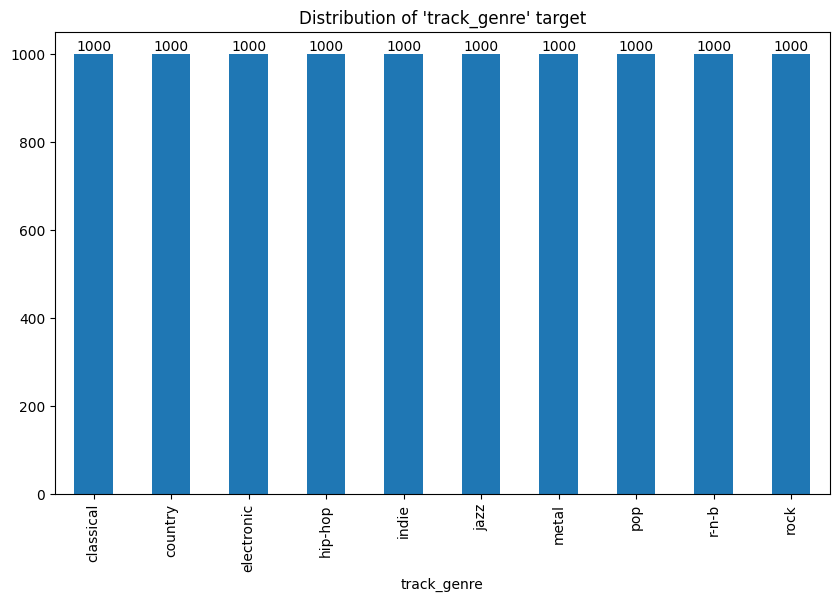

In [15]:
# show data imbalance:
import matplotlib.pyplot as plt

# Plot the distribution of player_class with counts
value_counts = loaded_df[dataset_config['target']].value_counts()

# print the target values
print(f"Target values: {value_counts.index.tolist()}")

plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')

# Add counts as text labels on top of bars
for i, count in enumerate(value_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title(f"Distribution of '{dataset_config['target']}' target")

# -> the dataset is clearly balanced

In [16]:
from baseline_eval import evaluate_baseline, plot_model_performance_summary
results = evaluate_baseline(
    df=loaded_df,
    model='AGTabular',
    df_name=dataset_config['dataset_name'],
    label_col=dataset_config['target'],
    task_type=dataset_config['task'],
    textual_cols=textual_cols,
    k_folds=5,
    seed=0,
    max_samples=3000,
    output_path=f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250521_225505"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #53~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jan 15 19:18:46 UTC 2
CPU Count:          64
Memory Avail:       433.03 GB / 503.54 GB (86.0%)
Disk Space Avail:   33790.12 GB / 51214.59 GB (66.0%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1



[WRAPPER] Running stratified downsampling mode for task: clf
Info: 
[INFO] Downsampling dataframe: spotfy_genre (original rows: 10000)
Info: Trying to sample ~300 rows per class (total=3000)
Info: Final downsampled dataset has 3000 rows. Per class counts: [country: 300, hip-hop: 300, jazz: 300, rock: 300, metal: 300, pop: 300, electronic: 300, r-n-b: 300, classical: 300, indie: 300]

Downsampled 3000 rows for spotfy_genre dataset.


Beginning AutoGluon training ... Time limit = 360s
AutoGluon will save models to "/home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/AutogluonModels/ag-20250521_225505"
Train Data Rows:    2400
Train Data Columns: 18
Label Column:       track_genre
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 10
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    443426.80 MB
	Train Data (Original)  Memory Usage: 0.80 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator..

In [17]:
rs = pd.read_csv(f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv")
plot_model_performance_summary(name=dataset_config['dataset_name'],task=dataset_config['task'], df=rs)

Saving plot to ../../baseline_results/plots/clf/score
Saving plot to ../../baseline_results/plots/clf/loss
Saving plot to ../../baseline_results/plots/clf/roc_auc


{'score':                                     mean       std
 model                                             
 AutoGluon_Tabular_without_text  0.635667  0.013049
 AutoGluon_Tabular_with_text     0.734667  0.005821,
 'loss':                                     mean       std
 model                                             
 AutoGluon_Tabular_with_text     0.870805  0.045257
 AutoGluon_Tabular_without_text  1.182835  0.095833,
 'roc_auc':                                     mean       std
 model                                             
 AutoGluon_Tabular_without_text  0.922357  0.006047
 AutoGluon_Tabular_with_text     0.955882  0.003983}